# Graph Prediction Model
In this notebook, we run through an experiment using UserALE data generated within an instantiation of Superset.  This data reflects four simulated user sessions in which the user performs three tasks within the Video Game Sales example dashboard:

1. Filter the games for Wii, Racing, and Nintendo.
2. Find Mario Kart in the list of games.
3. Determine the difference in global sales between the 3DS game Nintendogs + cats and Wii Sports.

The data of these four sessions is captured in a json file within the data folder entitled `task_example.json`.  In this experiment, we will:

* Experiment with the efficacy of several predictive models to determine which is the best for our objective
* Attempt to plug the `DiGraph` objects resulting from `task_example.json` into the model we choose
* Tune the resulting model to minimize loss and maximize prediction accuracy

**Note: The data utilized in this example was not data collected in any user study.  Rather this data is simulated through developer interactions with the Superset dashboard.**

# Legacy Code:

Generates the graph lists and structures that we'll eventually use for reference.

In [1]:
import sys
sys.path.append('../')

import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re

def setup(file, date_type):
    with open(file) as json_file:
        raw_data = json.load(json_file)

    data = {}
    for log in raw_data:
        data[distill.getUUID(log)] = log
        
    # Convert clientTime to specified type
    for uid in data:
        log = data[uid]
        client_time = log['clientTime']
        if date_type == "integer":
            log['clientTime'] = distill.epoch_to_datetime(client_time)
        elif date_type == "datetime":
            log['clientTime'] = pd.to_datetime(client_time, unit='ms', origin='unix')

    # Sort
    sorted_data = sorted(data.items(), key=lambda kv: kv[1]['clientTime'])
    sorted_dict = dict(sorted_data)

    return (sorted_data, sorted_dict)

def draw_digraph(segments):
    nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
    edges = distill.pairwiseSeq(segments.get_segment_list())
    
    # Set coloring of graph based on element in Superset dashboard
    color_map = []
    for segment in segments:
        if re.match("Game_Filter\S*", segment.segment_name):
            color_map.append('green')
        else:
            color_map.append('blue')
    
    graph = distill.createDiGraph(nodes, edges)
    nx.draw(graph, node_color=color_map)
    return graph

In [2]:
data_many_session = setup("./data/task_example.json", "datetime")
sorted_dict = data_many_session[1]

# Create segments based on sessionID
segments = distill.Segments()
session_ids = sorted(distill.find_meta_values('sessionID', sorted_dict), key=lambda sessionID: sessionID)
for session_id in session_ids:
    segments.append_segments(distill.generate_collapsing_window_segments(sorted_dict, 'sessionID', [session_id], session_id))
    
# Improve readability of Segment names
for index in range(len(segments)):
    segments[index].segment_name = "Session" + str(index)
    
    
segment_names = [segment.segment_name for segment in segments]
start_end_vals = [segment.start_end_val for segment in segments]
segment_map = distill.write_segment(sorted_dict, segment_names, start_end_vals)

session_0_segments = distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_1_segments = distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_2_segments = distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_3_segments = distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")

session_0_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_1_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_2_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_3_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))

segments.append_segments(session_0_segments)
segments.append_segments(session_1_segments)
segments.append_segments(session_2_segments)
segments.append_segments(session_3_segments)

**Example user-activity graph:**

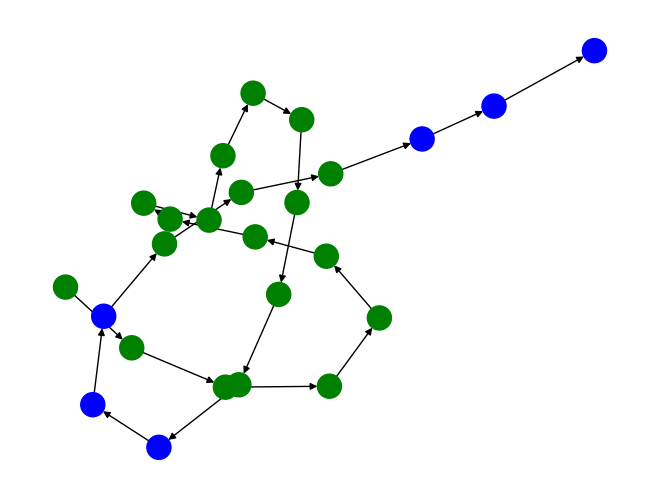

In [3]:
G0 = draw_digraph(session_0_segments)

# GAN Research / Fooling Around:

Source code found at https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4

Very basic task: Training a GAN to generate positive integers using vectors of their binary encodings (Ex: 56 is 0111000)

In [4]:
from typing import List
from typing import Tuple
import math

def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]

def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

**Building the Generator:**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

**Building the Discriminator**

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

**Training**

In [7]:
import numpy as np

def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 201):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)
        
        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).unsqueeze(1).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()
        # Print generator's loss at every 50th step
        if (i % 50)==0 :
          print("STEP ", str(i))
          print(generator_loss)

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        z = torch.zeros(batch_size).unsqueeze(1)
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, z)
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

In [8]:
train()

STEP  0
tensor(0.5157, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  50
tensor(0.5687, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  100
tensor(0.6151, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  150
tensor(0.6385, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  200
tensor(0.6650, grad_fn=<BinaryCrossEntropyBackward0>)


So essentially what we'd do for the graphs is, instead of feeding integers, we would feed session data. Feature vectors would represent [div_1, div_2, ..., div_n] with each element denoting whether or not an element was clicked at that segment of the session (vertex of the graph). Only problem is, human-made session data is not so easily generated as it is with random numbers in this example.

**Summary so far:**

So far, I've read:
* (GAN theory) https://www.frontiersin.org/articles/10.3389/fdata.2019.00003/full
* (undirected graphs GAN with tensorflow) https://github.com/hwwang55/GraphGAN (further documentation: https://arxiv.org/pdf/1711.08267.pdf)
* (directed graphs GAN with pytorch) https://github.com/THUDM/GraphSGAN (further documentation: https://arxiv.org/pdf/1809.00130.pdf)

As a result, I have a good idea of the theory and am currently working out how to reverse-engineer the third link which looks most promising. All my notes on this are currently in a word doc.

**Current Problems:**
* A GAN typically requires 50,000-100,000 images/graphs to train on, and we only have 4 graphs in the example
* Having a hard time percieving the third link's input data and how to translate ours to fit its format

**Questions:**
* How accurate would we want our GAN generator to be? (loss-wise)
* Realistically, how many training sessions can we get beyond the 4 that exist in the example json?
* Might be possible to generate the data in a way that doesn't require ML. Maybe through bots or something? Do we want the session data to strictly reflect the behavior of human users?
* What are we looking for in our model? For it to know a typical series of clicks that the average user might generate? In this case, should we consider an ngram-style neural network we could use as a sequence generator (replacing words with segments), instead?

**Input:**
* Stop working on GANs. Too much data is required for training.
* Start working on ngram NN
* Essentially: Predict the next graph in a series of graphs by averaging the past ones
* Purpose: Predicting future user activity based on their past activity. But for now, we will be using the activity of multiple users to predict future activity of the average user
* Aside: If it so happens that our model does not train well, there’s a chance it’s because the data we’re using is flawed. Inform them of this.


# Ngram NN Research / Fooling Around:

Investigating the structure of the segments for good measure (scrap once understood)

In [9]:
segments = session_0_segments
nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
edges = distill.pairwiseSeq(segments.get_segment_list())
print( "UIDS: ", nodes[24].get_segment_uids() )
print( "NAME: ", nodes[24].get_segment_name() )
print( "FIELD NAME: ", nodes[24].get_generate_field_name() )
print( "LENGTH: ", len(nodes) )

UIDS:  ['session_16527363465571652736427217rawmouseover', 'session_16527363465571652736427318rawscroll', 'session_16527363465571652736428683rawmouseover', 'session_16527363465571652736428699rawmouseover', 'session_16527363465571652736428763rawmouseover', 'session_16527363465571652736428909rawwheel', 'session_16527363465571652736428921rawscroll', 'session_16527363465571652736429603rawmouseover', 'session_16527363465571652736429779rawmouseover', 'session_16527363465571652736429835rawmouseover', 'session_16527363465571652736430013rawmouseover', 'session_16527363465571652736430117rawmouseover', 'session_16527363465571652736433401rawmouseover', 'session_16527363465571652736433433rawmouseover', 'session_16527363465571652736433465rawmouseover', 'session_16527363465571652736434235rawmouseover', 'session_16527363465571652736434331rawmouseover', 'session_16527363465571652736436417rawmouseover', 'session_16527363465571652736436433rawmouseover']
NAME:  Games5
FIELD NAME:  path
LENGTH:  25


**Ngram was scrapped in favor of GNNs until further notice.** See https://arxiv.org/pdf/2202.06081.pdf for inspiration.

# GNN Research / Fooling Around:

Read through the following sources/tutorials:

- General GNN overview information: https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
- More GNN overview information: https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275
- Link Prediction with planetary Cora dataset: https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
- Graph classification with Heterogeneous data: https://blog.dataiku.com/graph-neural-networks-merging-deep-learning-with-graphs

Ultimately decided on building our prototype from the following tutorial due to the fact that we want a model for Link Prediction of homogeneous graphs with complex node structure (Segment objects): https://blog.dataiku.com/graph-neural-networks-link-prediction-part-two
Even though the data in this link's graph is heterogeneous, the concept application is the same.

Began implementing the Cora planetary dataset code before realizing their data is very heterogeneous and graph structure seems a little more dissimilar to ours. May revisit if it otherwise becomes especially interesting

In [10]:
# %%capture
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# os.environ['PYTHONWARNINGS'] = "ignore"
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [11]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# print(f'Dataset: {dataset}:')
# print('======================')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

# data = dataset[0]  # Get the first graph object.
# print(data)

**Implementation of the more-relevant heterogeneous graph dataiku tutorial instead:**

Note: The "mean aggregator" as mentioned in https://blog.dataiku.com/graph-neural-networks-link-prediction-part-two may be especially useful

Goal: Predict the rating that a given user is likely to give to the most recent movies. This prediction would then be used to suggest the most relevant movie.

Modeling: The problem can be modeled as a graph with two types of nodes: one representing users and the other movies. A user node is linked to the movie node if the user has rated the movie and is labeled with the rating.

Task: Under this modeling, the problem becomes a link prediction task where the goal is to predict the label (rating) of a link between a user node and a movie node.

Their Original code: https://github.com/linafaik08/graph_neural_networks/blob/main/2_link_prediction.ipynb

My concerns:
- This code depends on user-movie relationships (how do we strip away the user aspect?)
- This code uses a KNN approach (maps movies' feature vectors into a vector space and suggests links between nodes in those K classes from there)
- Link prediction creates a matrix of all possible edges that could exist between all existent nodes

**Our repurposed tutorial code:**

Tutorials proved too far from the problem to offer anything beyond niche understandings of the link prediction process, so I scraped them. May return back if they prove helpful

**From Scratch:**

(Not shown) I tried one version that was very specific to our data, but it started to become a mess with how many transitory methods I had to use to translate the graphs from one state to another and so on. 

Instead, I eventually decided to go very simple and build from there:

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np

# Define the LSTM model class
class GraphLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GraphLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.fc(lstm_out.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

# Define a function to preprocess the data
def preprocess_data(graphs):
    X, y = [], []
    for graph in graphs:
        nodes = list(graph.nodes())
        for i in range(len(nodes) - 1):
            X.append(np.array(nodes[i]))
            y.append(np.array(nodes[i+1]))
    X = np.array(X)
    y = np.array(y)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

# Define the main function to train the model
def train_model(graphs, input_size, hidden_size, output_size, num_epochs):
    # Preprocess the data
    X, y = preprocess_data(graphs)

    # Initialize the model, loss function, and optimizer
    model = GraphLSTM(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        hidden = model.init_hidden()
        loss = 0
        for i in range(X.shape[0]):
            model.zero_grad()
            output, hidden = model(X[i], hidden)
            loss += criterion(output, y[i])
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    return model

# Test the model on a sample graph with the most basic data
if __name__ == '__main__':
    # Define a sample graph
    G = nx.DiGraph()
    G.add_edges_from([(1,2), (2,3), (2,4), (3,4), (4,1)])

    # Train the model on a list of graphs
    graphs = [G]
    input_size = 1
    hidden_size = 10
    output_size = 1
    num_epochs = 2000
    model = train_model(graphs, input_size, hidden_size, output_size, num_epochs)

    # Test the model by predicting the next most probable node (after 4) in the graph
    input_node = torch.tensor([4], dtype=torch.float32)
    hidden = model.init_hidden()
    output, hidden = model(input_node, hidden)
    predicted_node = round( max(output.detach().numpy()[0]) )
#     print(f'input node: {input_node}')
    print(f'Nodes: {G.nodes()}')
    print(f'Output: {output}')
    print(f'Predicted next node: {predicted_node}')

Epoch 1/2000, Loss: 30.820568084716797
Epoch 2/2000, Loss: 30.726964950561523
Epoch 3/2000, Loss: 30.633541107177734
Epoch 4/2000, Loss: 30.540298461914062
Epoch 5/2000, Loss: 30.44723129272461
Epoch 6/2000, Loss: 30.354345321655273
Epoch 7/2000, Loss: 30.261629104614258
Epoch 8/2000, Loss: 30.169082641601562
Epoch 9/2000, Loss: 30.076696395874023
Epoch 10/2000, Loss: 29.984466552734375
Epoch 11/2000, Loss: 29.892375946044922
Epoch 12/2000, Loss: 29.8004150390625
Epoch 13/2000, Loss: 29.708580017089844
Epoch 14/2000, Loss: 29.61684799194336
Epoch 15/2000, Loss: 29.52520751953125
Epoch 16/2000, Loss: 29.433639526367188
Epoch 17/2000, Loss: 29.34212303161621
Epoch 18/2000, Loss: 29.250640869140625
Epoch 19/2000, Loss: 29.15916633605957
Epoch 20/2000, Loss: 29.067676544189453
Epoch 21/2000, Loss: 28.976146697998047
Epoch 22/2000, Loss: 28.884553909301758
Epoch 23/2000, Loss: 28.79286766052246
Epoch 24/2000, Loss: 28.70105743408203
Epoch 25/2000, Loss: 28.609092712402344
Epoch 26/2000, Los

Epoch 244/2000, Loss: 1.625201940536499
Epoch 245/2000, Loss: 1.594138503074646
Epoch 246/2000, Loss: 1.563776969909668
Epoch 247/2000, Loss: 1.534103512763977
Epoch 248/2000, Loss: 1.5051054954528809
Epoch 249/2000, Loss: 1.4767706394195557
Epoch 250/2000, Loss: 1.449084758758545
Epoch 251/2000, Loss: 1.4220376014709473
Epoch 252/2000, Loss: 1.3956156969070435
Epoch 253/2000, Loss: 1.3698062896728516
Epoch 254/2000, Loss: 1.3445981740951538
Epoch 255/2000, Loss: 1.3199803829193115
Epoch 256/2000, Loss: 1.2959398031234741
Epoch 257/2000, Loss: 1.2724660634994507
Epoch 258/2000, Loss: 1.2495487928390503
Epoch 259/2000, Loss: 1.2271746397018433
Epoch 260/2000, Loss: 1.2053346633911133
Epoch 261/2000, Loss: 1.184017539024353
Epoch 262/2000, Loss: 1.1632128953933716
Epoch 263/2000, Loss: 1.1429096460342407
Epoch 264/2000, Loss: 1.1230982542037964
Epoch 265/2000, Loss: 1.103767991065979
Epoch 266/2000, Loss: 1.0849093198776245
Epoch 267/2000, Loss: 1.0665130615234375
Epoch 268/2000, Loss: 1

Epoch 501/2000, Loss: 0.33559930324554443
Epoch 502/2000, Loss: 0.33508843183517456
Epoch 503/2000, Loss: 0.3345780670642853
Epoch 504/2000, Loss: 0.3340686559677124
Epoch 505/2000, Loss: 0.33355996012687683
Epoch 506/2000, Loss: 0.333051860332489
Epoch 507/2000, Loss: 0.3325444459915161
Epoch 508/2000, Loss: 0.3320378065109253
Epoch 509/2000, Loss: 0.33153200149536133
Epoch 510/2000, Loss: 0.33102700114250183
Epoch 511/2000, Loss: 0.3305223882198334
Epoch 512/2000, Loss: 0.3300187885761261
Epoch 513/2000, Loss: 0.3295157849788666
Epoch 514/2000, Loss: 0.32901352643966675
Epoch 515/2000, Loss: 0.32851189374923706
Epoch 516/2000, Loss: 0.32801082730293274
Epoch 517/2000, Loss: 0.3275107145309448
Epoch 518/2000, Loss: 0.3270112872123718
Epoch 519/2000, Loss: 0.32651254534721375
Epoch 520/2000, Loss: 0.3260144591331482
Epoch 521/2000, Loss: 0.3255169689655304
Epoch 522/2000, Loss: 0.3250201940536499
Epoch 523/2000, Loss: 0.3245241940021515
Epoch 524/2000, Loss: 0.3240289092063904
Epoch 52

Epoch 749/2000, Loss: 0.22914265096187592
Epoch 750/2000, Loss: 0.22878874838352203
Epoch 751/2000, Loss: 0.22843526303768158
Epoch 752/2000, Loss: 0.22808240354061127
Epoch 753/2000, Loss: 0.22773025929927826
Epoch 754/2000, Loss: 0.2273787409067154
Epoch 755/2000, Loss: 0.22702743113040924
Epoch 756/2000, Loss: 0.22667676210403442
Epoch 757/2000, Loss: 0.22632655501365662
Epoch 758/2000, Loss: 0.22597697377204895
Epoch 759/2000, Loss: 0.2256281077861786
Epoch 760/2000, Loss: 0.2252795398235321
Epoch 761/2000, Loss: 0.22493158280849457
Epoch 762/2000, Loss: 0.22458384931087494
Epoch 763/2000, Loss: 0.22423699498176575
Epoch 764/2000, Loss: 0.22389057278633118
Epoch 765/2000, Loss: 0.22354474663734436
Epoch 766/2000, Loss: 0.22319939732551575
Epoch 767/2000, Loss: 0.22285456955432892
Epoch 768/2000, Loss: 0.22251014411449432
Epoch 769/2000, Loss: 0.22216640412807465
Epoch 770/2000, Loss: 0.22182326018810272
Epoch 771/2000, Loss: 0.2214803546667099
Epoch 772/2000, Loss: 0.22113831341266

Epoch 998/2000, Loss: 0.15583333373069763
Epoch 999/2000, Loss: 0.15559335052967072
Epoch 1000/2000, Loss: 0.1553535759449005
Epoch 1001/2000, Loss: 0.15511426329612732
Epoch 1002/2000, Loss: 0.1548750251531601
Epoch 1003/2000, Loss: 0.1546366959810257
Epoch 1004/2000, Loss: 0.15439844131469727
Epoch 1005/2000, Loss: 0.1541605293750763
Epoch 1006/2000, Loss: 0.15392325818538666
Epoch 1007/2000, Loss: 0.15368624031543732
Epoch 1008/2000, Loss: 0.15344978868961334
Epoch 1009/2000, Loss: 0.1532134711742401
Epoch 1010/2000, Loss: 0.15297771990299225
Epoch 1011/2000, Loss: 0.1527421772480011
Epoch 1012/2000, Loss: 0.1525072306394577
Epoch 1013/2000, Loss: 0.1522725224494934
Epoch 1014/2000, Loss: 0.15203851461410522
Epoch 1015/2000, Loss: 0.15180453658103943
Epoch 1016/2000, Loss: 0.151571124792099
Epoch 1017/2000, Loss: 0.15133799612522125
Epoch 1018/2000, Loss: 0.15110541880130768
Epoch 1019/2000, Loss: 0.150873064994812
Epoch 1020/2000, Loss: 0.15064138174057007
Epoch 1021/2000, Loss: 0.

Epoch 1254/2000, Loss: 0.10639979690313339
Epoch 1255/2000, Loss: 0.10625055432319641
Epoch 1256/2000, Loss: 0.10610156506299973
Epoch 1257/2000, Loss: 0.10595288872718811
Epoch 1258/2000, Loss: 0.10580460727214813
Epoch 1259/2000, Loss: 0.10565648972988129
Epoch 1260/2000, Loss: 0.10550869256258011
Epoch 1261/2000, Loss: 0.10536132007837296
Epoch 1262/2000, Loss: 0.10521432757377625
Epoch 1263/2000, Loss: 0.10506749153137207
Epoch 1264/2000, Loss: 0.10492098331451416
Epoch 1265/2000, Loss: 0.10477473586797714
Epoch 1266/2000, Loss: 0.10462900996208191
Epoch 1267/2000, Loss: 0.1044834703207016
Epoch 1268/2000, Loss: 0.10433812439441681
Epoch 1269/2000, Loss: 0.10419308394193649
Epoch 1270/2000, Loss: 0.10404849797487259
Epoch 1271/2000, Loss: 0.10390421003103256
Epoch 1272/2000, Loss: 0.10376010090112686
Epoch 1273/2000, Loss: 0.10361640155315399
Epoch 1274/2000, Loss: 0.10347293317317963
Epoch 1275/2000, Loss: 0.10332987457513809
Epoch 1276/2000, Loss: 0.10318705439567566
Epoch 1277/2

Epoch 1503/2000, Loss: 0.07776305079460144
Epoch 1504/2000, Loss: 0.07767756283283234
Epoch 1505/2000, Loss: 0.07759227603673935
Epoch 1506/2000, Loss: 0.0775071308016777
Epoch 1507/2000, Loss: 0.07742219418287277
Epoch 1508/2000, Loss: 0.0773373395204544
Epoch 1509/2000, Loss: 0.07725280523300171
Epoch 1510/2000, Loss: 0.07716847956180573
Epoch 1511/2000, Loss: 0.07708442956209183
Epoch 1512/2000, Loss: 0.07700048387050629
Epoch 1513/2000, Loss: 0.07691656798124313
Epoch 1514/2000, Loss: 0.07683301717042923
Epoch 1515/2000, Loss: 0.07674954831600189
Epoch 1516/2000, Loss: 0.07666638493537903
Epoch 1517/2000, Loss: 0.07658333331346512
Epoch 1518/2000, Loss: 0.07650045305490494
Epoch 1519/2000, Loss: 0.07641778141260147
Epoch 1520/2000, Loss: 0.07633522152900696
Epoch 1521/2000, Loss: 0.07625291496515274
Epoch 1522/2000, Loss: 0.07617080211639404
Epoch 1523/2000, Loss: 0.07608883082866669
Epoch 1524/2000, Loss: 0.0760071724653244
Epoch 1525/2000, Loss: 0.07592534273862839
Epoch 1526/200

Epoch 1750/2000, Loss: 0.06097542867064476
Epoch 1751/2000, Loss: 0.06091932952404022
Epoch 1752/2000, Loss: 0.060863301157951355
Epoch 1753/2000, Loss: 0.0608072392642498
Epoch 1754/2000, Loss: 0.06075150519609451
Epoch 1755/2000, Loss: 0.06069562956690788
Epoch 1756/2000, Loss: 0.060639746487140656
Epoch 1757/2000, Loss: 0.060584135353565216
Epoch 1758/2000, Loss: 0.06052836775779724
Epoch 1759/2000, Loss: 0.060472603887319565
Epoch 1760/2000, Loss: 0.06041708588600159
Epoch 1761/2000, Loss: 0.06036152318120003
Epoch 1762/2000, Loss: 0.060305919498205185
Epoch 1763/2000, Loss: 0.06025054678320885
Epoch 1764/2000, Loss: 0.06019510701298714
Epoch 1765/2000, Loss: 0.060139790177345276
Epoch 1766/2000, Loss: 0.060084421187639236
Epoch 1767/2000, Loss: 0.06002930551767349
Epoch 1768/2000, Loss: 0.05997399240732193
Epoch 1769/2000, Loss: 0.05991886183619499
Epoch 1770/2000, Loss: 0.05986368656158447
Epoch 1771/2000, Loss: 0.05980861559510231
Epoch 1772/2000, Loss: 0.05975382402539253
Epoch

Epoch 1990/2000, Loss: 0.048461735248565674
Epoch 1991/2000, Loss: 0.04841174557805061
Epoch 1992/2000, Loss: 0.048361461609601974
Epoch 1993/2000, Loss: 0.048311565071344376
Epoch 1994/2000, Loss: 0.04826144129037857
Epoch 1995/2000, Loss: 0.04821128770709038
Epoch 1996/2000, Loss: 0.04816129803657532
Epoch 1997/2000, Loss: 0.048111189156770706
Epoch 1998/2000, Loss: 0.04806114733219147
Epoch 1999/2000, Loss: 0.04801109805703163
Epoch 2000/2000, Loss: 0.04796108603477478
Nodes: [1, 2, 3, 4]
Output: tensor([[2.5982]], grad_fn=<AddmmBackward0>)
Predicted next node: 3


Now we try plugging our G0,G1,G2,G3 graph data in (work in progress):

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np

# Define the LSTM model class
class GraphLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GraphLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.fc(lstm_out.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

# Define a function to preprocess the data
def preprocess_data(graphs):
    X, y = [], []
    for graph in graphs:
        nodes = list(graph.nodes())
        for i in range(len(nodes) - 1):
            X.append(np.array(nodes[i]))
            y.append(np.array(nodes[i+1]))
    X = np.array(X)
    y = np.array(y)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

# Define the main function to train the model
def train_model(graphs, input_size, hidden_size, output_size, num_epochs):
    # Preprocess the data
    X, y = preprocess_data(graphs)

    # Initialize the model, loss function, and optimizer
    model = GraphLSTM(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        hidden = model.init_hidden()
        loss = 0
        for i in range(X.shape[0]):
            model.zero_grad()
            output, hidden = model(X[i], hidden)
            loss += criterion(output, y[i])
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    return model

# # Test the model on a sample graph with the most basic data
# if __name__ == '__main__':
#     # Define a sample graph
#     G = nx.DiGraph()
#     G.add_edges_from([(1,2), (2,3), (2,4), (3,4), (4,1)])

#     # Train the model on a list of graphs
#     graphs = [G]
#     input_size = 1
#     hidden_size = 10
#     output_size = 1
#     num_epochs = 100
#     model = train_model(graphs, input_size, hidden_size, output_size, num_epochs)

#     # Test the model by predicting the next node in the graph
#     input_node = torch.tensor([4], dtype=torch.float32)
#     hidden = model.init_hidden()
#     output, hidden = model(input_node, hidden)
#     predicted_node = torch.argmax(output).item()
#     print(f'Predicted next node: {predicted_node}')

# Test the model on a sample graph with the most basic data
if __name__ == '__main__':

    # Train the model on a list of graphs
    graphs = [G0, G1, G2]
    input_size = 3
    hidden_size = 10
    output_size = 1
    num_epochs = 100
    model = train_model(graphs, input_size, hidden_size, output_size, num_epochs)

    # Test the model by predicting the next node in the graph
    
    # Problem: G3 needs to be turned into an embedding of type float32
    input_node = torch.tensor([G3], dtype=torch.float32)
    hidden = model.init_hidden()
    output, hidden = model(input_node, hidden)
    predicted_node = max(output.tolist())
#     print(f'input node: {input_node}')
    print(f'Nodes: {G.nodes()}')
    print(f'Output: {output.tolist()}')
    print(f'Predicted next node: {predicted_node}')

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

**Next objective:** Find a way to translate the segment objects into autoencoded embeddings for training before translating them back into the predicted output segment we need